<a href="https://colab.research.google.com/github/mvakhmenin/Yandex.Practicum/blob/main/%D0%AF%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D1%83%D0%BC(Yandex_Practicum)_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2_%D0%98%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0%D0%B4%D1%91%D0%B6%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B7%D0%B0%D1%91%D0%BC%D1%89%D0%B8%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/datasets/data.csv')
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


**Описание данных**
* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [ ]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [ ]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

**Вывод**:
1. Ошибок в именах столбцов нет, исправлять не нужно.
2. Количество пропусков в столбце days_employed равно количеству пропусков в графе total_income. Возможно, это связано с тем, что люди, в которые раньше не работали у них и дохода не было. Это нужно проверить.
3. В столбцах children и days_employed есть отрицательные значения. Нужно их обработать.
4. В столбце days_employed максимальное значение составляет 401755.400475	(более 1100 лет). Значения более возраста респондента минус 15 лет являются некорректными. Кроме того более 75% значений являются отрицательными. Необходимо их как-то обработать.
5. В столбце dob_years минимальное значение 0. Клиентов с возрастом менее 18 лет мы не можем рассматривать.
6. Тип данных столбца days_employed должен быть целочисленным, а не вещественным.

## Шаг 2. Предобработка данных

### Обработка пропусков


In [ ]:
data_na = data.loc[data.days_employed.isna() & data.total_income.isna(), :]
if data_na.shape[0] == (21525 - 19351):
  print('Нулевой доход только у тех людей, которые раньше не работали')
  data.fillna(0, inplace=True)
data.info()

Нулевой доход только у тех людей, которые раньше не работали
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

В результате фильтрации пропущенных значний было установлено, что пустое значение в столбце total_income только у людей, у которых пустое значение в столбце days_employed. То есть те люди, которые раньше не работали, у них и дохода не было. Поэтому можно пропущенные значения в столбцах days_employed и total_income заменить нулями. Других пропусков в данных нет.

### Замена типа данных

In [ ]:
data = data.astype({'days_employed': np.int64})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  int64  
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


**Вывод**

Тип данных столбца days_employed заменен на целочисленный (int64) с помоцью метода astype, так как дни трудового стажа имеет смысл указывать целым числом.

### Обработка дубликатов

Выведем все значения по столбцам с текстовыми переменными

In [ ]:
for cat_var in ['education', 'family_status', 'income_type', 'purpose']:
  print(f'Столбец "{cat_var}"')
  print(data[cat_var].value_counts())
  print('='*45)
  print()

Столбец "education"
среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Столбец "family_status"
женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Столбец "income_type"
сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

Столбец "purpose"
свадьба                    

Неявные дубликаты есть в столбцах "education" и "purpose". Уберем в ручную дубликаты из столбца "education"

In [ ]:
data_no_dups = data.copy()
data_no_dups["education"] = data_no_dups["education"].str.lower()
data_no_dups["education"].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

**Вывод**

Дубликаты из столбца "education" были удалены путем перевода всех значений в нижний регистр. Возможная причина появления - человеческих фактор при вводе значений.

Дубликаты из столбца "purpose", будут удалены в процессе лемматизации.

### Проверка значений

Проверка значений в столбцах:
* children и days_employed есть отрицательные значения. В столбце days_employed более 75% значений являются отрицательными

Проанализируем значения столбца children

In [ ]:
data_no_dups[data_no_dups['children']<0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,-4417,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
705,-1,-902,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
742,-1,-3174,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
800,-1,349987,54,среднее,1,Не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование
941,-1,0,57,среднее,1,женат / замужем,0,F,пенсионер,0,0.000000,на покупку своего автомобиля
1363,-1,-1195,55,среднее,1,женат / замужем,0,F,компаньон,0,69550.699692,профильное образование
1929,-1,-1461,38,среднее,1,Не женат / не замужем,4,M,сотрудник,0,109121.569013,покупка жилья
2073,-1,-2539,42,среднее,1,в разводе,3,F,компаньон,0,162638.609373,покупка жилья
3814,-1,-3045,26,среднее,1,гражданский брак,1,F,госслужащий,0,131892.785435,на проведение свадьбы
4201,-1,-901,41,среднее,1,женат / замужем,0,F,госслужащий,0,226375.766751,операции со своей недвижимостью


In [ ]:
print('Количество отрицательных значений в столбце "children":',data_no_dups[data_no_dups['children']<0]['children'].count())

Количество отрицательных значений в столбце "children": 47


Возможные причины появления отрицательных значений не просматриваются. Похоже на техническую ошибку. Исключим эти значения из дальнейшего анализа зависимости просрочки по кредиту от наличия детей. К счастью, их всего 47.

* days_employed максимальное значение составляет 401755.400475 (более 1100 лет). Значения более возраста респондента минус 15 лет являются некорректными. 

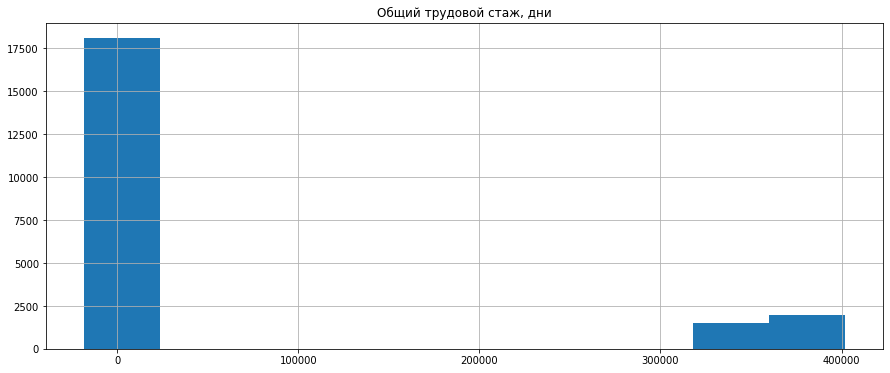

In [ ]:
data_no_dups['days_employed'].hist(figsize=(15,6))
plt.title('Общий трудовой стаж, дни')
None

Есть небольшое количество значений более 300 000 (более 800 лет). Они явно не корректные.

Посмотрим на эти значения.

In [ ]:
data_no_dups[data_no_dups['days_employed']>300000]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
18,0,400281,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823.777243,на покупку подержанного автомобиля
24,1,338551,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547.235997,операции с коммерческой недвижимостью
25,0,363548,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112.757732,покупка недвижимости
30,1,335581,62,среднее,1,женат / замужем,0,F,пенсионер,0,171456.067993,операции с коммерческой недвижимостью
...,...,...,...,...,...,...,...,...,...,...,...,...
21505,0,338904,53,среднее,1,гражданский брак,1,M,пенсионер,0,75439.993167,сыграть свадьбу
21508,0,386497,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638.590915,недвижимость
21509,0,362161,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029.059379,операции с недвижимостью
21518,0,373995,59,среднее,1,женат / замужем,0,F,пенсионер,0,153864.650328,сделка с автомобилем


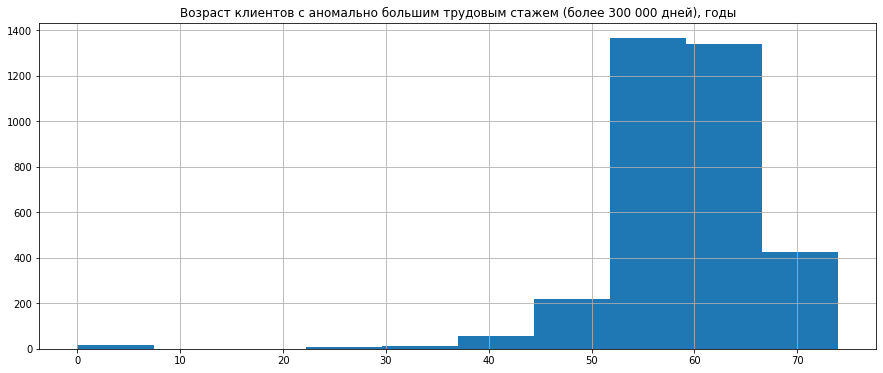

In [ ]:
data_no_dups[data_no_dups['days_employed']>300000]['dob_years'].hist(figsize=(15,6))
plt.title('Распределение возраста клиентов c аномально большим трудовым стажем (более 300 000 дней), годы')
None

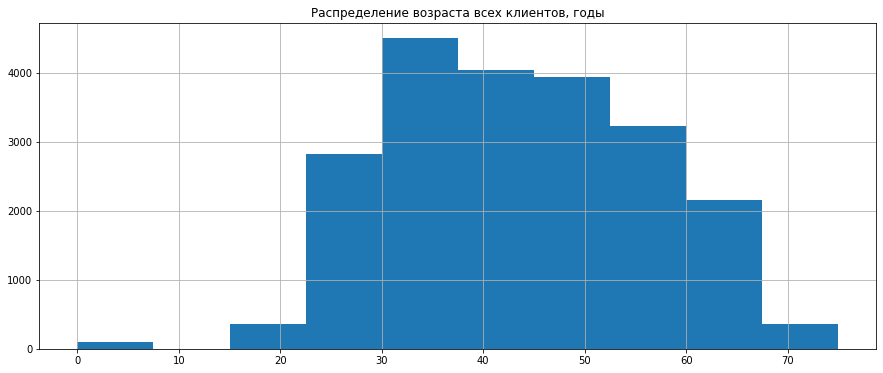

In [ ]:
data_no_dups['dob_years'].hist(figsize=(15,6))
plt.title('Распределение возраста всех клиентов, годы')
None

Единственное, что можно сказать, что аномально большие значения трудового стажа в основном у клиентов старшего возраста (более 50 лет). Но они все равно жили не достаточно, чтобы так долго работать.

Теперь посмотрим на значения трудового стажа без аномально высоких значений (более 300 000 дней)

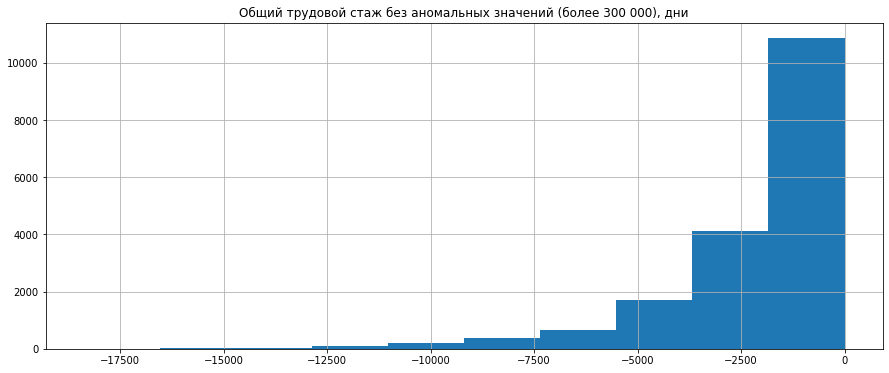

In [ ]:
data_no_dups[data_no_dups['days_employed']<300000]['days_employed'].hist(figsize=(15,6))
plt.title('Общий трудовой стаж без аномальных значений (более 300 000), дни')
None

Все значения отрицательные. Возможно, стаж записывается с неправильным знаком.

* dob_years минимальное значение 0. Клиентов с возрастом менее 18 лет мы не можем рассматривать

In [ ]:
data_no_dups.loc[data_no_dups['dob_years']<18, :]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,346541,0,среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,-2664,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,-1872,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,397856,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,-1158,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль
...,...,...,...,...,...,...,...,...,...,...,...,...
19829,0,0,0,среднее,1,женат / замужем,0,F,сотрудник,0,0.000000,жилье
20462,0,338734,0,среднее,1,женат / замужем,0,F,пенсионер,0,259193.920299,покупка своего жилья
20577,0,331741,0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,129788.762899,недвижимость
21179,2,-108,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости


Чуть более 101 клиент имеют возраст 0. Возможно, какая-то техническая ошибка

**Вывод**
К сожалению, причины появления ошибочных значений установить не удалось.

К счастью, столбцы 'dob_years' и 'days_employed' не участвуют в дальнейшем анализе. Отрицательные значения столбца 'children' будут исключены из анализа. Их всего 47 и такое исклюение не окажет заметного влияния на результат.

### Лемматизация

In [ ]:
from pymystem3 import Mystem
m = Mystem()

def set_new_purpose(row):
  #lems = m.lemmatize(row['purpose'])
  lems = m.lemmatize(row)
  if 'свадьба' in lems:
    return 'свадьба'
  elif ('недвижимость' in lems) or ('жилье' in lems):
    if 'строительство' in lems:
      return 'строительство недвижимости'
    elif 'ремонт' in lems:
      return 'ремонт недвижимости'
    else: return 'покупка недвижимости'
  elif 'автомобиль' in lems:
    return 'покупка автомобиля'
  elif 'образование' in lems:
    return 'получение образования'

data_no_dups['purpose_cats'] = data_no_dups['purpose'].apply(set_new_purpose)

**Вывод**

### Категоризация данных

Категоризация по количеству детей. Разделим всех клиентов на две категории: с детьми и без

In [ ]:
data_no_dups['children_bool'] = data_no_dups['children'].apply(lambda x: x>0)
data_no_dups

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_bool
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,True
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,True
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,False
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,True
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,True
21521,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,False
21522,1,-2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,True
21523,3,-3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,True


Категоризация по уровню дохода. Будем делить в соответствии с квартильным распределением: менее 100 000 - бедные, от 100 000 до 145 000 - ниже среднего, от 145 000 до 200 000 - выше среднего, более 200 000 - богатые.

In [ ]:
def set_income_cat(row):
  if row < 100000: return 'бедные'
  elif 100000 <= row < 145000: return 'ниже среднего'
  elif 145000 <= row < 200000: return 'выше среднего'
  else: return 'богатые'

data_no_dups['income_cats'] = data_no_dups['total_income'].apply(set_income_cat)
data_no_dups

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,children_bool,income_cats
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,True,богатые
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,True,ниже среднего
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,False,выше среднего
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,True,богатые
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,False,выше среднего
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,True,богатые
21521,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем,False,выше среднего
21522,1,-2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,True,бедные
21523,3,-3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,True,богатые


**Вывод**

Категоризация данных выполнена

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [ ]:
# в связи с тем, что не удалось установить причину появления отрицательных значений в столбце 'children',
# исключим отрицательные значения из анализа 
children_debt = data_no_dups[data_no_dups['children']>=0].groupby('children_bool').agg({'children_bool': 'count', 'debt': 'sum'})
children_debt['%'] = children_debt['debt'] / children_debt['children_bool'] * 100
pd.options.display.float_format ='{:,.1f}'.format
children_debt.index = ['Нет детей', 'Есть дети']
children_debt.columns = ['Кол-во клиентов', 'Была задолженность', '%']
children_debt

,Кол-во клиентов,Была задолженность,%
Нет детей,14149,1063,7.5
Есть дети,7329,677,9.2


**Вывод**

У клиентов с детьми вероятность просрочки выплаты по кредиту выше. Возможно, это связано с более высокими расходами из-за детей и высоким риском возникновения непредвиденных расходов.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [ ]:
family_status_debt = data_no_dups.groupby('family_status').agg({'family_status': 'count', 'debt': 'sum'})
family_status_debt['%'] = family_status_debt['debt'] / family_status_debt['family_status'] * 100
pd.options.display.float_format ='{:,.1f}'.format
family_status_debt.index.name = 'Семейное положение'
family_status_debt.columns = ['Кол-во клиентов', 'Была задолженность', '%']
family_status_debt

,Кол-во клиентов,Была задолженность,%
Семейное положение,,,
Не женат / не замужем,2813,274,9.7
в разводе,1195,85,7.1
вдовец / вдова,960,63,6.6
гражданский брак,4177,388,9.3
женат / замужем,12380,931,7.5


**Вывод**

Самая высокая вероятность просрочки выплат по кредиту у клиентов, которые не состоят в официальном браке (Не женат / не замужем	и гражданский брак). Значительно меньше вероятность просрочки выплат по кредиту у клиентов, которые либо состоят в браке, либо состояли в браке ранее (женат / замужем и в разводе). Самая низкая вероятность просрочки выплат по кредиту у клиентов, которые потеряли супруга.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [ ]:
income_debt = data_no_dups.groupby('income_cats').agg({'income_cats': 'count', 'debt': 'sum'})
income_debt['%'] = income_debt['debt'] / income_debt['income_cats'] * 100
income_debt.index.name = 'Уровень дохода'
income_debt.columns = ['Кол-во клиентов', 'Была задолженность', '%']
income_debt.reindex(['бедные', 'ниже среднего', 'выше среднего', 'богатые'])

,Кол-во клиентов,Была задолженность,%
Уровень дохода,,,
бедные,6637,524,7.9
ниже среднего,5211,450,8.6
выше среднего,4611,409,8.9
богатые,5066,358,7.1


**Вывод**

Меньше всего вероятность просрочки выплат по кредиту у самых богатых, что можно объяснить наличием большого объема денежных средств и, вероятно, нескольких источников дохода. Следом за ними идут самые бедные. Низких риск у них можно объяснить осторожностью в связи с ограниченными финансовыми возможностями - они не берут большие кредиты, потому что не уверены в стабильной финансовой ситуации в будущем. "Средний класс" имеет самую высокую вероятность просрочки выплат по кредитам. Возможно, это связано с излишней самоуверенностью в собственных финансовых возможностях.

- Как разные цели кредита влияют на его возврат в срок?

**Вывод**

## Шаг 4. Общий вывод

Семейное положение и количество детей клиента оказывают влияние на факт погашения кредита в срок. Наличие детей отрицтельно сказывается на вероятности погашения кредита в срок. В плане семейного положения стоит отдавать предпочтение разведенным и потерявшим супруга клиентам.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [ ]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.